# [TP Final](https://github.com/jipphysics/redes-neuronales-2023/blob/main/tf-2023.pdf) - Redes Neuronales

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb




## Importando librerías y datasets

In [ ]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [ ]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict
import copy

In [ ]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json
import seaborn as sn

In [ ]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [ ]:
# 1.4)
import google.colab
from google.colab import files

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
# 2.1)
# transform = transforms.Compose([transforms.ToTensor()
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # esto es para cuando quiero componer varias transformaciones juntas
# transform = transforms.ToTensor()

train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = ToTensor())
test_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = ToTensor())

In [ ]:
# train_size, valid_size = 50000, 10000
# train_set_orig, valid_set_orig = random_split(train_set_orig, [train_size, valid_size])

In [ ]:
labels_names = {
    0: "T-Shirt",    # Remera manga corta
    1: "Trouser",    # Pantalon
    2: "Pullover",   # Buzo
    3: "Dress",      # Vestido
    4: "Coat",       # Abrigo
    5: "Sandal",     # Sandalia
    6: "Shirt",      # Remera manga larga
    7: "Sneaker",    # Zapatilla
    8: "Bag",        # Bolso
    9: "Ankle Boot", # Bota
}

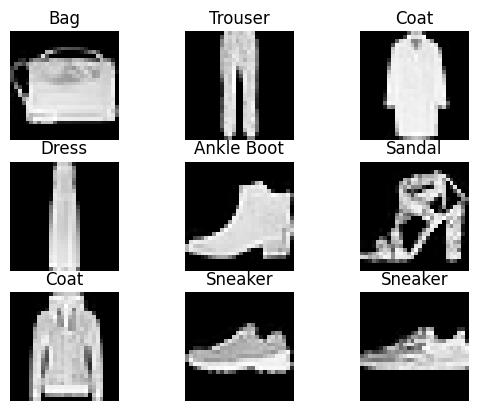

In [ ]:
# Hago la figura de 3x3
fig, axs = plt.subplots(3,3)

for ax_ in axs:
  for ax in ax_:
    j = torch.randint(len(train_set_orig),size=(1,)).item()
    image, label = train_set_orig[j]
    ax.title.set_text(labels_names[label])
    ax.axis('off')
    ax.imshow(image.squeeze(), cmap = 'Greys_r')

## Funciones a correr

In [ ]:
# 3.1)
class CustomDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  # Redefinimos el método .__len__()
  def __len__(self):
    return len(self.dataset)
  # Redefinimos el método .__getitem__()
  def __getitem__(self,i):
    image,label=self.dataset[i]
    input  = image
    output = torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
    return input, input

In [ ]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset

train_set = CustomDataset(train_set_orig)
# valid_set = CustomDataset(valid_set_orig)
# test_set = CustomDataset(test_set_orig)

valid_set = CustomDataset(test_set_orig)

In [ ]:
# 4.1)
class Autoencoder_Conv(nn.Module):
  def __init__(self, n, p=0.2):
    super().__init__() # Toma los metodos en init de la clase q estoy heredando, equivalente a hacer "nn.Module.__init__()"
    self.flatten = nn.Flatten()
    self.n = n
    self.p = p
    self.encoder = nn.Sequential(
        # Convolutional
        nn.Conv2d(1, 16, kernel_size = 3), # (1,28,28) -> (16,26,26)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2), # (16,26,26) -> (16,13,13)

        # Convolutional
        nn.Conv2d(16, 32, kernel_size = 3), # (16,13,13) -> (32,11,11)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2), # (32,11,11) -> (32,5,5)

        # Linear
        nn.Flatten(),  # (32,5,5) -> (32*5*5)
        nn.Linear(32*5*5, n), # (32*5*5) -> n
        nn.ReLU(),
        nn.Dropout(p)
    )

    self.decoder = nn.Sequential(
        # Linear
        nn.Linear(n, 32*5*5), # n -> (32*5*5)
        nn.ReLU(),
        nn.Dropout(p),
        nn.Unflatten(1, (32,5,5)), # (32*5*5) -> (32,5,5)

        # Convolutional transpose
        nn.ConvTranspose2d(32, 16, kernel_size = 4, stride = 2, output_padding = 1), # (32,5,5) -> (16,13,13)
        nn.ReLU(),
        nn.Dropout(p),

        # Convolutional transpose
        nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, output_padding = 1), # (16,13,13) -> (1,28,28)
        nn.Sigmoid()
    )

  def forward(self, x):#, Train = False):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
def batch(x):
  return x.unsqueeze(0) # (1,28,28) -> (1,1,28,28)  Lo devuelve como si estuviera dentro de un batch

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

In [ ]:
# 5.1)
def train_loop(dataloader, model, loss_fn, optimizer, text = True, clasificador = False):
  # Activamos el entrenamiento
  model.train()
  # Defino constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss, sum_correct = 0,0

  # Movemos el modelo a la GPU
  model = model.to(device)

  # Itero sobre los batches
  for batch, (X, y) in enumerate(dataloader):
    # Copiamos las entradas y las salidas al dispositivo de trabajo --> IMPORTANTE DEFINIR DEVICE
    X = X.to(device)
    y = y.to(device)
    # Calculamos la predicción del modelo y la correspondiente pérdida (error)
    pred = model(X)
    loss = loss_fn(pred,y)
    # Backpropagamos usando el optimizador provisto.
    optimizer.zero_grad() # Setea en 0 los valores de los gradientes
    loss.backward() # Calcula los gradientes
    optimizer.step() # Actualiza los pesos
    # Imprimimos el progreso...
    loss_value = loss.item()
    sum_loss += loss_value

    if clasificador:
      # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
      sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch_size*batch % 10000 == 0 and text == True:
      current = batch*len(X)
      print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")

  avg_loss = sum_loss/num_batches

  if clasificador:
    precision = sum_correct/size
    return avg_loss, precision

  return avg_loss

def valid_loop(dataloader, model, loss_fn, clasificador = False):
  # Activamos el entrenamiento
  model.eval()
  # Defino constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss, sum_correct = 0,0

  # Movemos el modelo a la GPU
  model = model.to(device)

  with torch.no_grad():
    # Itero sobre los batches
    for X, y in dataloader:
      # Copiamos las entradas y las salidas al dispositivo de trabajo --> IMPORTANTE DEFINIR DEVICE
      X = X.to(device)
      y = y.to(device)
      # Calculamos la predicción del modelo y la correspondiente pérdida (error)
      pred = model(X)
      sum_loss += loss_fn(pred,y).item()

      if clasificador:
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  avg_loss = sum_loss/num_batches

  if clasificador:
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss, precision

  print(f"@valid_loop avg_loss={avg_loss:>8f}")
  return avg_loss


In [ ]:
# 4.1)
class Clasificador_Conv(nn.Module):
  def __init__(self, n, p=0.2, autoencoder = None, sigmoid = False):
    super().__init__() # Toma los metodos en init de la clase q estoy heredando, equivalente a hacer "nn.Module.__init__()"
    self.flatten = nn.Flatten()

    self.pretraining = False
    if autoencoder is None:

      self.n = n
      self.p = p
      self.encoder = nn.Sequential(
          # Convolutional
          nn.Conv2d(1, 16, kernel_size = 3), # (1,28,28) -> (16,26,26)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (16,26,26) -> (16,13,13)

          # Convolutional
          nn.Conv2d(16, 32, kernel_size = 3), # (16,13,13) -> (32,11,11)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (32,11,11) -> (32,5,5)

          # Linear
          nn.Flatten(),  # (32,5,5) -> (32*5*5)
          nn.Linear(32*5*5, n), # (32*5*5) -> n
          nn.ReLU(),
          nn.Dropout(p)
      )
      print('Encoder Creado!')
    else:
      self.n = autoencoder.n
      self.p = autoencoder.p
      self.pretraining = True
      self.encoder = copy.deepcopy(autoencoder.encoder)
      print('Encoder Copiado!')

    if sigmoid:
      self.clasificador = nn.Sequential(
          nn.Linear(self.n, 10),
          nn.Sigmoid()
      )
    else:
      self.clasificador = nn.Sequential(
          nn.Linear(self.n, 10),
          nn.ReLU()
      )

  def forward(self, x):#, Train = False):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

# ANALISIS DEFINITIVO

El objetivo va a ser variar los parámetros para poder conseguir el mejor autoencoder y posteriormente el mejor clasificador que podamos

No voy a joder con el pooling pero si puedo decir si bien al autoencoder le jode que se nos corte la imagen ya que altera los pixeles de los extremos que para la ECM son igual de importantes. Sin embargo para el clasificador estos pixeles que no conyevan informacion clave sobre el objeto y por lo tanto no van a significar un deterioro de la clasificacion.

NO NECESARIAMENTE UN MEJOR AUTOENCODER HACE UN MEJOR CLASIFICADOR, YA QUE AL CLASIFICADOR NO LE INTERESAN LOS DETALLES.

## Básico: n = 64, lr=0.001, batch = 100, dropout = 0.2

# ANALISIS PREVIO

### Creo un DataSet personalizado

In [ ]:
# 3.1)
class CustomDataset(Dataset):
  def __init__(self, dataset):
    self.dataset = dataset
  # Redefinimos el método .__len__()
  def __len__(self):
    return len(self.dataset)
  # Redefinimos el método .__getitem__()
  def __getitem__(self,i):
    image,label=self.dataset[i]
    input  = image
    output = torch.flatten(image) # Reescribimos el label original con una version achatada de la imagen.
    return input, input

In [ ]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset

train_set = CustomDataset(train_set_orig)
# valid_set = CustomDataset(valid_set_orig)
# test_set = CustomDataset(test_set_orig)

valid_set = CustomDataset(test_set_orig)

In [ ]:
len(train_set)

60000

## Parte 1) Autoencoder Convolucional



**1)** Defina y cree una red neuronal autoenconder convolucional.
El **encoder** deberá estar constituido por las siguientes capas:

Primero una capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) de entrada $(1,28, 28)$ a una salida de dimensiones $(16,26, 26)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(16,26,26)$ a salidas de dimensiones $(16,13,13)$.

Luego otra capa convolucional 2D constituida por:

* Una capa `Conv2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) de entrada $(16,13,13)$ a una salida de dimensiones $(32,11,11)$. Para ello utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
Una capa ReLU.
Una capa Dropout.
* Una capa `MaxPool` (ver https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) con un kernel de dimensiones $(2,2)$, de manera que mapeará entradas de dimensiones $(32,11,11)$ a salidas de dimensiones $(32,5,5)$.

Luego una capa lineal constituida por:

* Una capa `Flatten` que mapea dimensiones $(32,5,5)$ a dimensión $(32 * 5 * 5)$.
* Una capa `Linear` que mapea dimensión $(32 * 5 * 5)$ a un vector de dimensión $n$.
* Una capa `ReLU`.
* Una capa `Dropout`.

El **decoder** deberá estar constituido por las siguientes capas:

Primero una capa lineal constituida por:

* Una capa `Linear` que mapea dimensión $n$ a un vector de dimensión $(32 * 5 * 5)$.
* Una capa `ReLU`.
* Una capa `Dropout`.
* Una capa `Unflatten` que mapea dimensión $(32 * 5 * 5)$ a dimensión $(32,5,5)$.

**Luego una capa convolucional 2D transpuesta, constituida por:**

* una capa `ConvTranspose2d` (ver https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) que mapea dimensiones $(32,5,5)$ dimensiones $(16,13,13)$. Para ello, utilice un kernel_size de dimensiones $(4,4)$ y un stride de dimensiones $(2,2)$ y un output_padding de $(1,1)$, dejando el resto de los parámetros en sus valores por defecto.
* Una capa `Sigmoid`.
<!-- * Una capa `Dropout`. -->

**2)** Grafique, comparativamente, las imagenes a predecir vs las imagenes predichas por el modelo sin entrenar usando $n=64$ y dropout $p=0.2$.

In [ ]:
# 4.1)
class Autoencoder_Conv(nn.Module):
  def __init__(self, n, p=0.2):
    super().__init__() # Toma los metodos en init de la clase q estoy heredando, equivalente a hacer "nn.Module.__init__()"
    self.flatten = nn.Flatten()
    self.n = n
    self.p = p
    self.encoder = nn.Sequential(
        # Convolutional
        nn.Conv2d(1, 16, kernel_size = 3), # (1,28,28) -> (16,26,26)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2), # (16,26,26) -> (16,13,13)

        # Convolutional
        nn.Conv2d(16, 32, kernel_size = 3), # (16,13,13) -> (32,11,11)
        nn.ReLU(),
        nn.Dropout(p),
        nn.MaxPool2d(2,2), # (32,11,11) -> (32,5,5)

        # Linear
        nn.Flatten(),  # (32,5,5) -> (32*5*5)
        nn.Linear(32*5*5, n), # (32*5*5) -> n
        nn.ReLU(),
        nn.Dropout(p)
    )

    self.decoder = nn.Sequential(
        # Linear
        nn.Linear(n, 32*5*5), # n -> (32*5*5)
        nn.ReLU(),
        nn.Dropout(p),
        nn.Unflatten(1, (32,5,5)), # (32*5*5) -> (32,5,5)

        # Convolutional transpose
        nn.ConvTranspose2d(32, 16, kernel_size = 4, stride = 2, output_padding = 1), # (32,5,5) -> (16,13,13)
        nn.ReLU(),
        nn.Dropout(p),

        # Convolutional transpose
        nn.ConvTranspose2d(16, 1, kernel_size = 3, stride = 2, output_padding = 1), # (16,13,13) -> (1,28,28)
        nn.Sigmoid()
    )

  def forward(self, x):#, Train = False):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
n,p = 64, 0.2
model = Autoencoder_Conv(n, p)

In [ ]:
def batch(x):
  return x.unsqueeze(0) # (1,28,28) -> (1,1,28,28)  Lo devuelve como si estuviera dentro de un batch

def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

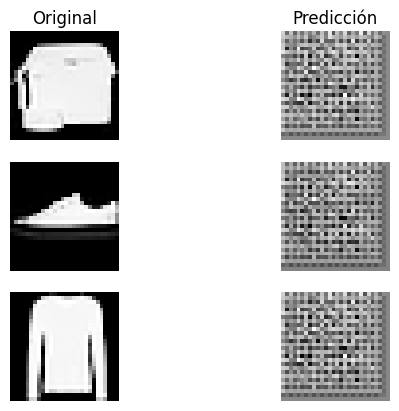

In [ ]:
# Hago la figura de 3x3
fig, axs = plt.subplots(3,2)
label = {0: 'Original', 1: 'Predicción'}
model.eval()
model.to(device)
for i, ax_ in enumerate(axs):
  j = torch.randint(len(train_set),size=(1,)).item()
  image, _ = train_set[j]
  for k, ax in enumerate(ax_):
    ax.axis('off')
    if i==0:
      ax.title.set_text(label[k])
    if k==0:
      ax.imshow(image.squeeze(), cmap = 'Greys_r')
    else:
      image_gpu = image.to(device)
      # print(batch(image_gpu).shape)
      pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
      pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
      ax.imshow(pred_cpu, cmap = 'Greys_r')

## Parte 2) Entrenando el autoencoder

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con $n=64$ neuronas en la capa intermedia y dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)**  Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader` respectivamente, usando un número arbitrario de épocas. Este loop debe guardar en dos listas los valores de los promedios del **ECM** sobre el conjunto de entrenamiento y el de validación, respectivamente..

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **3.7)** para graficar en función de las épocas la **ECM** y la **Precisión** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otros valores de $n$, el optimizador **SGD**, otros valores de **dropout**, otros valores de **learning-rate**, otros tamaños de **batchs** y agregando **ReLU**s (y dropouts) en la capa de salida.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [ ]:
# 5.1)
def train_loop(dataloader, model, loss_fn, optimizer, text = True, clasificador = False):
  # Activamos el entrenamiento
  model.train()
  # Defino constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss, sum_correct = 0,0

  # Movemos el modelo a la GPU
  model = model.to(device)

  # Itero sobre los batches
  for batch, (X, y) in enumerate(dataloader):
    # Copiamos las entradas y las salidas al dispositivo de trabajo --> IMPORTANTE DEFINIR DEVICE
    X = X.to(device)
    y = y.to(device)
    # Calculamos la predicción del modelo y la correspondiente pérdida (error)
    pred = model(X)
    loss = loss_fn(pred,y)
    # Backpropagamos usando el optimizador provisto.
    optimizer.zero_grad() # Setea en 0 los valores de los gradientes
    loss.backward() # Calcula los gradientes
    optimizer.step() # Actualiza los pesos
    # Imprimimos el progreso...
    loss_value = loss.item()
    sum_loss += loss_value

    if clasificador:
      # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
      sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch_size*batch % 10000 == 0 and text == True:
      current = batch*len(X)
      print(f"@train_loop batch={batch:>5d} loss={loss_value:>7f}  muestras-procesadas=[{current:>5d}/{size:>5d}]")

  avg_loss = sum_loss/num_batches

  if clasificador:
    precision = sum_correct/size
    return avg_loss, precision

  return avg_loss

def valid_loop(dataloader, model, loss_fn, clasificador = False):
  # Activamos el entrenamiento
  model.eval()
  # Defino constantes
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  sum_loss, sum_correct = 0,0

  # Movemos el modelo a la GPU
  model = model.to(device)

  with torch.no_grad():
    # Itero sobre los batches
    for X, y in dataloader:
      # Copiamos las entradas y las salidas al dispositivo de trabajo --> IMPORTANTE DEFINIR DEVICE
      X = X.to(device)
      y = y.to(device)
      # Calculamos la predicción del modelo y la correspondiente pérdida (error)
      pred = model(X)
      sum_loss += loss_fn(pred,y).item()

      if clasificador:
        # También calculamos el número de predicciones correctas, y lo acumulamos en un total.
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

  avg_loss = sum_loss/num_batches

  if clasificador:
    precision = sum_correct/size
    print(f"@valid_loop precision={(100*precision):>0.1f}% avg_loss={avg_loss:>8f}")
    return avg_loss, precision

  print(f"@valid_loop avg_loss={avg_loss:>8f}")
  return avg_loss


### Entreno n=64 -- valid_loop avg_loss=0.037261

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# Entrenamiento iterando en epocas
num_epochs = 20

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.179046  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.079932  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.063647  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.056483  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.053030  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.052162  muestras-procesadas=[50000/60000]
Training set:
@valid_loop avg_loss=0.047033
Validation set:
@valid_loop avg_loss=0.047070

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.047308  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.048055  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.047255  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.047544  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.045316  muestras-procesadas=[40000/60000]
@train_loop batch=  500 lo

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'modelo_entrenado_P2_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_avg_loss_inc': list_train_avg_loss_inc,  # Convertir el array a una dimensión
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_P2_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

In [ ]:
# Crear una instancia del modelo
model = Autoencoder_Conv(n=n, p=p)

# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)

# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'modelo_entrenado_P2_64.pth')
model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

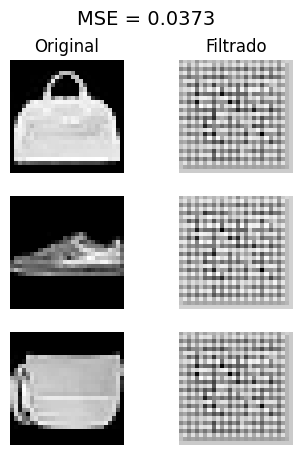

In [ ]:
# Lo pongo a prueba...
# Hago la figura de 3x3
fig, axs = plt.subplots(3,2,figsize = (4,5))
label = {0: 'Original', 1: 'Filtrado'}
model.eval()
for i, ax_ in enumerate(axs):
  j = torch.randint(len(train_set),size=(1,)).item()
  image, _ = train_set[j]
  for k, ax in enumerate(ax_):
    ax.axis('off')
    if i==0:
      ax.title.set_text(label[k])
    if k==0:
      ax.imshow(image.squeeze(), cmap = 'Greys_r')
    else:
      image_gpu = image.to(device)
      pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
      pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
      ax.imshow(pred_cpu, cmap = 'Greys_r')
fig.suptitle(f'MSE = {list_valid_avg_loss[-1]:.4f}', fontsize=14)
plt.show( )

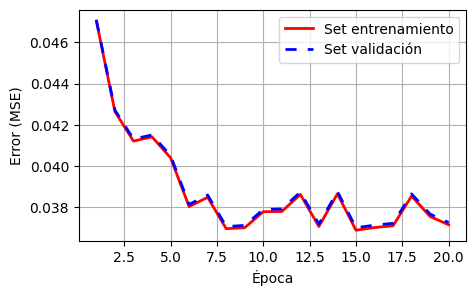

In [ ]:
plt.figure(figsize = (5,3))

# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss,label="Set validación",linestyle=(0,(4,4)),c='blue', lw = 2)
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()

### Pruebo variantes


64: @valid_loop avg_loss=0.036639 o 0.037 (REFERENCIA)

128: @valid_loop avg_loss=0.030721

256: @valid_loop avg_loss=0.030641

512: @valid_loop avg_loss=0.029154

----------------------------------

batch 1000: 0.0436

batch 10: 0.037016

-------------------------------

p=0.05: 0.025174

p=0.01: 0.022691

p=0.001: 0.022952

p=0.005: 0.023021

----------------------------

lr= 0.0001 -- loss: 0.042028 (suaviza la curva pero porque no logra bajar de 0.042 que es donde se hace lio para el de lr=0.001)

lr= 0.01 -- loss: 0.037016 (se hace todavia mas rugosa)




BATCH 1000 -- valid_loop avg_loss=0.043659

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 1000
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# Entrenamiento iterando en epocas
num_epochs = 15

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=0.147870  muestras-procesadas=[    0/60000]
@train_loop batch=   10 loss=0.124303  muestras-procesadas=[10000/60000]
@train_loop batch=   20 loss=0.108906  muestras-procesadas=[20000/60000]
@train_loop batch=   30 loss=0.096830  muestras-procesadas=[30000/60000]
@train_loop batch=   40 loss=0.088818  muestras-procesadas=[40000/60000]
@train_loop batch=   50 loss=0.082146  muestras-procesadas=[50000/60000]
Training set:
@valid_loop avg_loss=0.075798
Validation set:
@valid_loop avg_loss=0.075503

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.077558  muestras-procesadas=[    0/60000]
@train_loop batch=   10 loss=0.074612  muestras-procesadas=[10000/60000]
@train_loop batch=   20 loss=0.071016  muestras-procesadas=[20000/60000]
@train_loop batch=   30 loss=0.068820  muestras-procesadas=[30000/60000]
@train_loop batch=   40 loss=0.067036  muestras-procesadas=[40000/60000]
@train_loop batch=   50 lo

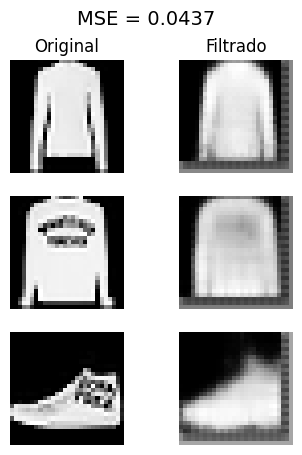

In [ ]:
# Lo pongo a prueba...
# Hago la figura de 3x3
fig, axs = plt.subplots(3,2,figsize = (4,5))
label = {0: 'Original', 1: 'Filtrado'}
model.eval()
for i, ax_ in enumerate(axs):
  j = torch.randint(len(train_set),size=(1,)).item()
  image, _ = train_set[j]
  for k, ax in enumerate(ax_):
    ax.axis('off')
    if i==0:
      ax.title.set_text(label[k])
    if k==0:
      ax.imshow(image.squeeze(), cmap = 'Greys_r')
    else:
      image_gpu = image.to(device)
      pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
      pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
      ax.imshow(pred_cpu, cmap = 'Greys_r')
fig.suptitle(f'MSE = {list_valid_avg_loss[-1]:.4f}', fontsize=14)
plt.show( )

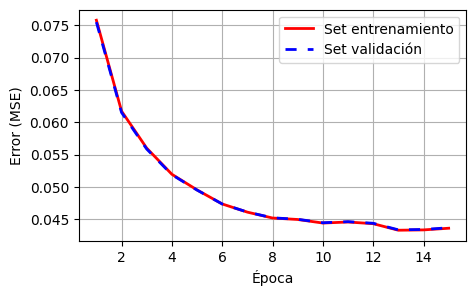

In [ ]:
plt.figure(figsize = (5,3))

# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss,label="Set validación",linestyle=(0,(4,4)),c='blue', lw = 2)
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()

BATCH 10 -- valid_loop avg_loss=?

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 10
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-4 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

# Entrenamiento iterando en epocas
num_epochs = 15

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Device: cpu
Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.047755
Validation set:
@valid_loop avg_loss=0.047761

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.041337
Validation set:
@valid_loop avg_loss=0.041374

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.040343
Validation set:
@valid_loop avg_loss=0.040383

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.038308
Validation set:
@valid_loop avg_loss=0.038352

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.036868
Validation set:
@valid_loop avg_loss=0.036926

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.036292
Validation set:
@valid_loop avg_loss=0.036361

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.037130
Validation set:
@valid_loop avg_loss=0.037196

Epoch 8
-------------------------------
Training set:
@valid_loop avg_l

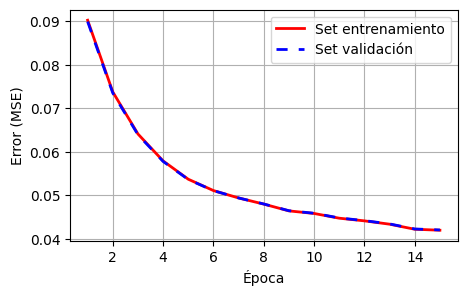

In [ ]:
plt.figure(figsize = (5,3))

# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss,label="Set validación",linestyle=(0,(4,4)),c='blue', lw = 2)
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()

VARIO lr= 0.0001 -- loss: 0.042028

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-4 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

# Entrenamiento iterando en epocas
num_epochs = 15

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Device: cpu
Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.090266
Validation set:
@valid_loop avg_loss=0.089946

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.073766
Validation set:
@valid_loop avg_loss=0.073516

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.064102
Validation set:
@valid_loop avg_loss=0.063930

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.057897
Validation set:
@valid_loop avg_loss=0.057786

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.053690
Validation set:
@valid_loop avg_loss=0.053629

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.051085
Validation set:
@valid_loop avg_loss=0.051068

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.049386
Validation set:
@valid_loop avg_loss=0.049386

Epoch 8
-------------------------------
Training set:
@valid_loop avg_l

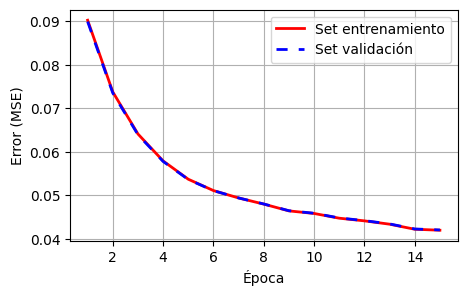

In [ ]:
plt.figure(figsize = (5,3))

# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss,label="Set validación",linestyle=(0,(4,4)),c='blue', lw = 2)
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()

VARIO lr= 0.01 -- loss: ?

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-2 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

# Entrenamiento iterando en epocas
num_epochs = 15

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Device: cpu
Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.043527
Validation set:
@valid_loop avg_loss=0.043633

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.037592
Validation set:
@valid_loop avg_loss=0.037715

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.039858
Validation set:
@valid_loop avg_loss=0.039961

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.042050
Validation set:
@valid_loop avg_loss=0.042132

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.038929
Validation set:
@valid_loop avg_loss=0.038992

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.040355
Validation set:
@valid_loop avg_loss=0.040440

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.038817
Validation set:
@valid_loop avg_loss=0.038882

Epoch 8
-------------------------------
Training set:
@valid_loop avg_l

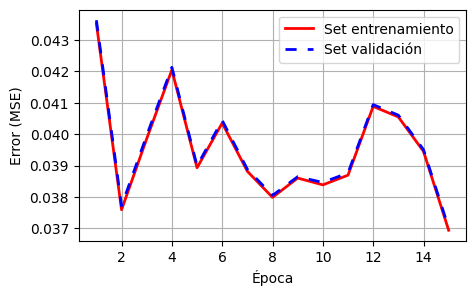

In [ ]:
plt.figure(figsize = (5,3))

# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss,label="Set validación",linestyle=(0,(4,4)),c='blue', lw = 2)
plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()

VARIO p= 0.1

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

# Entrenamiento iterando en epocas
num_epochs = 15

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Device: cpu
Epoch 1
-------------------------------


KeyboardInterrupt: 

### 4 diferentes n

In [ ]:
list_n = np.array([64, 128, 256, 512])
p = 0.2
num_epochs = 10

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-2 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.048482
Validation set:
@valid_loop avg_loss=0.048514

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.044609
Validation set:
@valid_loop avg_loss=0.044677

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.040217
Validation set:
@valid_loop avg_loss=0.040295

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.038913
Validation set:
@valid_loop avg_loss=0.039008

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.037584
Validation set:
@valid_loop avg_loss=0.037669

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.037357
Validation set:
@valid_loop avg_loss=0.037463

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.037542
Validation set:
@valid_loop avg_loss=0.037648

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.037254

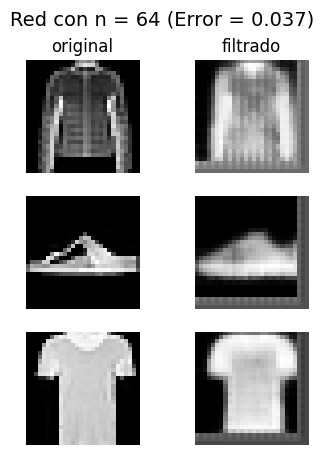

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.047485
Validation set:
@valid_loop avg_loss=0.047540

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.040298
Validation set:
@valid_loop avg_loss=0.040392

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.036671
Validation set:
@valid_loop avg_loss=0.036770

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.033910
Validation set:
@valid_loop avg_loss=0.034024

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.031902
Validation set:
@valid_loop avg_loss=0.032015

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.031357
Validation set:
@valid_loop avg_loss=0.031472

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.030809
Validation set:
@valid_loop avg_loss=0.030930

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.030962

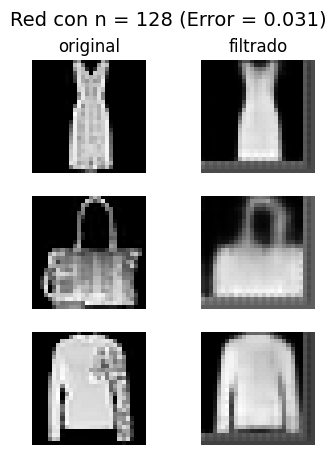

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.039813
Validation set:
@valid_loop avg_loss=0.039894

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.037505
Validation set:
@valid_loop avg_loss=0.037618

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.036760
Validation set:
@valid_loop avg_loss=0.036889

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.033719
Validation set:
@valid_loop avg_loss=0.033871

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.032983
Validation set:
@valid_loop avg_loss=0.033141

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.032298
Validation set:
@valid_loop avg_loss=0.032444

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.030929
Validation set:
@valid_loop avg_loss=0.031086

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.030940

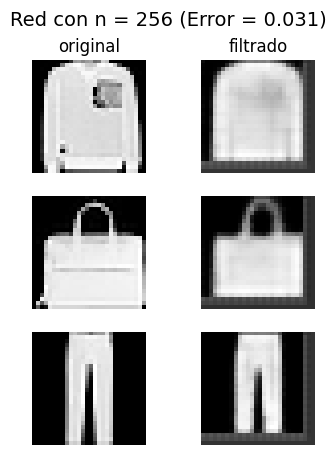

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.040178
Validation set:
@valid_loop avg_loss=0.040244

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.035165
Validation set:
@valid_loop avg_loss=0.035277

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.033958
Validation set:
@valid_loop avg_loss=0.034080

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.031355
Validation set:
@valid_loop avg_loss=0.031502

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.031685
Validation set:
@valid_loop avg_loss=0.031834

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.030881
Validation set:
@valid_loop avg_loss=0.031034

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.030611
Validation set:
@valid_loop avg_loss=0.030768

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.029280

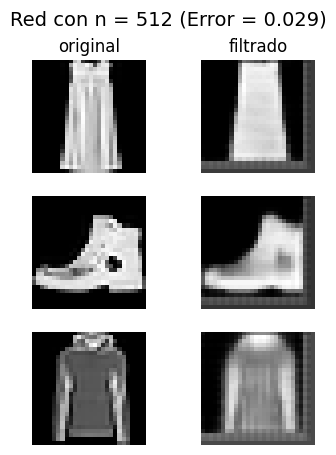

In [ ]:
list_train_avg_loss_inc = np.zeros((4,num_epochs))
list_train_avg_loss = np.zeros((4,num_epochs))
list_valid_avg_loss = np.zeros((4,num_epochs))
list_test_avg_loss = np.zeros(4)
modelos = []

for i, n in enumerate(list_n):
  # Definimos el modelo
  model = Autoencoder_Conv(n, p)

  # Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
  learning_rate = 1e-3 # necesario para definir
  # optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9, dampening = 0.3)
  optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

  for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
    print('Training set:')
    train_avg_loss = valid_loop(train_loader, model,loss_fn)
    print('Validation set:')
    valid_avg_loss = valid_loop(valid_loader, model,loss_fn)

    list_train_avg_loss_inc[i][epoch] = train_avg_loss_inc
    list_train_avg_loss[i][epoch] = train_avg_loss
    list_valid_avg_loss[i][epoch] = valid_avg_loss

  print(f'ENTRENAMIENTO n = {n} LISTO!')
  test_avg_loss = valid_loop(valid_loader, model,loss_fn)
  list_test_avg_loss[i] = test_avg_loss
  modelos.append(model)

  # Guardo el modelo entrenado como archivo de PyTorch
  torch.save({
      'modelo_state_dict': model.state_dict(),
      'optimizador_state_dict': optimizer.state_dict(),
  }, f'modelo_entrenado_vario_n_{n}.pth')

  # CON ADAM:
  # Hago la figura de 3x3
  fig, axs = plt.subplots(3,2, figsize = (4,5))
  label = {0: 'original', 1: 'filtrado'}
  model.eval()
  for i, ax_ in enumerate(axs):
    j = torch.randint(len(train_set),size=(1,)).item()
    image, _ = train_set[j]
    for k, ax in enumerate(ax_):
      ax.axis('off')
      if i==0:
        ax.title.set_text(label[k])
      if k==0:
        ax.imshow(image.squeeze(), cmap = 'Greys_r')
      else:
        image_gpu = image.to(device)
        pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
        pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
        ax.imshow(pred_cpu, cmap = 'Greys_r')
  fig.suptitle(f'Red con n = {n} (Error = {test_avg_loss:.3f})', fontsize=14)
  plt.show( )

In [ ]:
import pandas as pd

# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_avg_loss_inc': list_train_avg_loss_inc.ravel(),  # Convertir el array a una dimensión
    'list_train_avg_loss': list_train_avg_loss.ravel(),
    'list_valid_avg_loss': list_valid_avg_loss.ravel()
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv('losses_df_vario_n_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

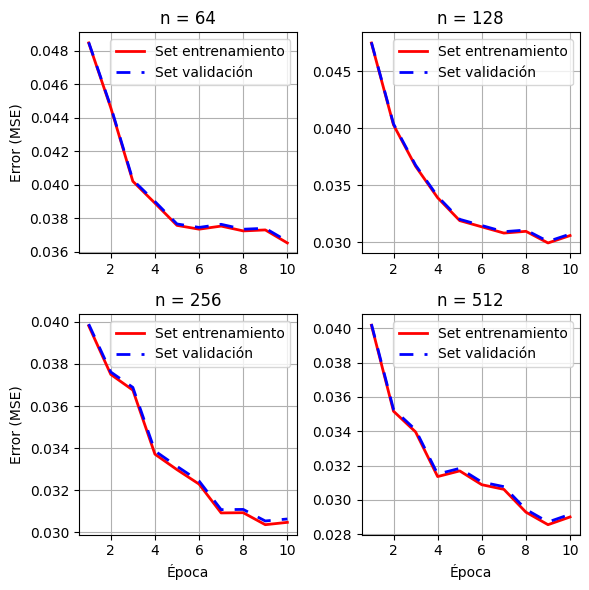

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(6,6))

for i, n in enumerate(list_n):
  ax = axs.ravel()[i]
  ax.plot(range(1,num_epochs+1),list_train_avg_loss[i],label="Set entrenamiento",linestyle='-',c='red', lw = 2)
  ax.plot(range(1,num_epochs+1),list_valid_avg_loss[i],label="Set validación",linestyle=(0,(5,4)),c='blue', lw = 2)
  if i>1: ax.set_xlabel('Época')
  if not i%2: ax.set_ylabel('Error (MSE)')
  ax.title.set_text(f'n = {n}')
  ax.grid()
  ax.legend()
fig.tight_layout()


### Varío Learning Rate

In [ ]:
list_lr = np.array([0.01, 0.001, 0.0001, 0.00001])
p = 0.2
num_epochs = 10

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 64, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-2 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
list_train_avg_loss_inc = np.zeros((4,num_epochs))
list_train_avg_loss = np.zeros((4,num_epochs))
list_valid_avg_loss = np.zeros((4,num_epochs))
list_test_avg_loss = np.zeros(4)
modelos = []

for i, lr in enumerate(list_lr):
  # Definimos el modelo
  model = Autoencoder_Conv(n = 64, p=0.2)

  # Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
  #learning_rate = 1e-3 # necesario para definir
  # optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9, dampening = 0.3)
  optimizer = torch.optim.Adam(model.parameters(),lr=lr,eps=1e-08,weight_decay=0,amsgrad=False)

  for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
    print('Training set:')
    train_avg_loss = valid_loop(train_loader, model,loss_fn)
    print('Validation set:')
    valid_avg_loss = valid_loop(valid_loader, model,loss_fn)

    list_train_avg_loss_inc[i][epoch] = train_avg_loss_inc
    list_train_avg_loss[i][epoch] = train_avg_loss
    list_valid_avg_loss[i][epoch] = valid_avg_loss

  print(f'ENTRENAMIENTO n = {n} LISTO!')
  test_avg_loss = valid_loop(valid_loader, model,loss_fn)
  list_test_avg_loss[i] = test_avg_loss
  modelos.append(model)

  # Guardo el modelo entrenado como archivo de PyTorch
  torch.save({
      'modelo_state_dict': model.state_dict(),
      'optimizador_state_dict': optimizer.state_dict(),
  }, f'modelo_entrenado_vario_lr_{lr}.pth')

  # CON ADAM:
  # Hago la figura de 3x3
  fig, axs = plt.subplots(3,2, figsize = (4,5))
  label = {0: 'original', 1: 'filtrado'}
  model.eval()
  for i, ax_ in enumerate(axs):
    j = torch.randint(len(train_set),size=(1,)).item()
    image, _ = train_set[j]
    for k, ax in enumerate(ax_):
      ax.axis('off')
      if i==0:
        ax.title.set_text(label[k])
      if k==0:
        ax.imshow(image.squeeze(), cmap = 'Greys_r')
      else:
        image_gpu = image.to(device)
        pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
        pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
        ax.imshow(pred_cpu, cmap = 'Greys_r')
  fig.suptitle(f'Red con lr = {lr} (Error = {test_avg_loss:.3f})', fontsize=14)
  plt.show( )

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.048482
Validation set:
@valid_loop avg_loss=0.048514

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.044609
Validation set:
@valid_loop avg_loss=0.044677

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.040217
Validation set:
@valid_loop avg_loss=0.040295

Epoch 4
-------------------------------


## Parte 3) Clasificador convolucional reutilizando el encoder

In [ ]:
# 4.1)
class Clasificador_Conv(nn.Module):
  def __init__(self, n, p=0.2, autoencoder = None):
    super().__init__() # Toma los metodos en init de la clase q estoy heredando, equivalente a hacer "nn.Module.__init__()"
    self.flatten = nn.Flatten()

    self.pretraining = False
    if autoencoder is None:

      self.n = n
      self.p = p
      self.encoder = nn.Sequential(
          # Convolutional
          nn.Conv2d(1, 16, kernel_size = 3), # (1,28,28) -> (16,26,26)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (16,26,26) -> (16,13,13)

          # Convolutional
          nn.Conv2d(16, 32, kernel_size = 3), # (16,13,13) -> (32,11,11)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (32,11,11) -> (32,5,5)

          # Linear
          nn.Flatten(),  # (32,5,5) -> (32*5*5)
          nn.Linear(32*5*5, n), # (32*5*5) -> n
          nn.ReLU(),
          nn.Dropout(p)
      )
      print('Encoder Creado!')
    else:
      self.n = autoencoder.n
      self.p = autoencoder.p
      self.pretraining = True
      self.encoder = copy.deepcopy(autoencoder.encoder)
      print('Encoder Copiado!')

    self.clasificador = nn.Sequential(
        nn.Linear(self.n, 10),
        nn.ReLU()
    )

  def forward(self, x):#, Train = False):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

Importo el encoder

In [ ]:
# Crear una instancia del modelo
model = Autoencoder_Conv(n=64, p=0.2)
# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)
# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'modelo_entrenado_P2_64.pth')
model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

autoencoder = model

### 50 Epocas

In [ ]:
model = Clasificador_Conv(n=64, p=0.2, autoencoder = autoencoder)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 50
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.593634  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=1.232051  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.948524  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.678597  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.629038  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.624588  muestras-procesadas=[50000/60000]
Training set:


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=64
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_entrenado_E50_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_E50_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

### 30 épocas

In [ ]:
model = Clasificador_Conv(n=64, p=0.2, autoencoder = autoencoder)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.500045  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.701527  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.632907  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.377697  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.636707  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.531574  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=82.9% avg_loss=0.478461
Validation set:
@valid_loop precision=81.7% avg_loss=0.499685

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.668742  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.565463  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.352373  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.378124  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.445740  muestras-procesadas=[40000/6

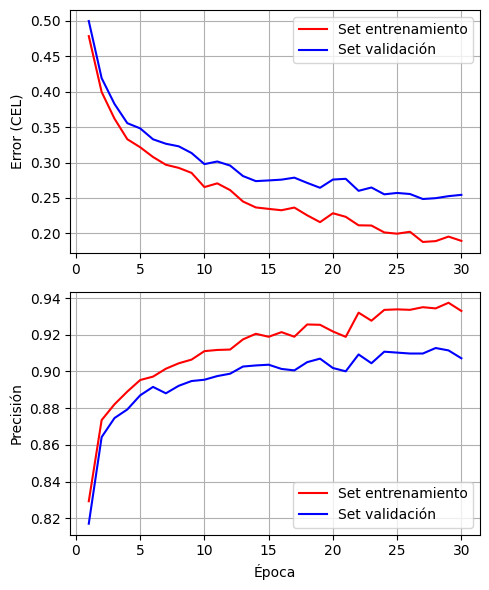

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=64
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif2_entrenado_E30_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif2_E30_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

#Matriz de confusión

tengo que volver a correr el loop de validación para cada

In [ ]:
def confusion_matrix(dataset, model):
  conf = np.zeros((10,10))
  label_count = np.zeros(10)
  # Activamos el entrenamiento
  model.eval()
  # Defino constantes
  size = len(dataset)
  sum_correct = 0

  # Movemos el modelo a la GPU
  model = model.to(device)

  with torch.no_grad():
    # Itero sobre el set completo
    for X, y in dataset:
      # Copiamos las entradas y las salidas al dispositivo de trabajo --> IMPORTANTE DEFINIR DEVICE
      X = X.to(device)
      # Calculamos la predicción del modelo y la correspondiente pérdida (error)
      pred = model(batch(X))
      sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

      label_count[y] += 1
      conf[y,pred.argmax(1)] += 1

  precision = sum_correct/size
  conf = (conf.T/label_count).T
  print(f"Matriz de confusión completada! Precision={(100*precision):>0.1f}%")
  return conf, precision

In [ ]:
# IMPORTO EL CLASIFICADOR ENTRENADO
archivo = 'clasif_entrenado_E30_64.pth'
# Crear una instancia del modelo
model = Clasificador_Conv(n=64, p=0.2)
# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)
# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(archivo)

model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

# IMPORTO LAS CURVAS
# df = pd.read_csv('losses_df_clasif_E30_64.csv')

# # Reconstruir los arrays NumPy
# list_train_precision = df['list_train_precision']
# list_valid_precision = df['list_valid_precision']  # Convertir el array a una dimensión
# list_train_avg_loss = df['list_train_avg_loss']
# list_valid_avg_loss = df['list_valid_avg_loss']

# # Ahora tienes tus arrays NumPy de nuevo
# print("Array1:\n", array1)
# print("Array2:\n", array2)
# print("Array3:\n", array3)

Encoder Creado!


In [ ]:
cm = confusion_matrix(test_set_orig, model)

Matriz de confusión completada! Precision=91.2%


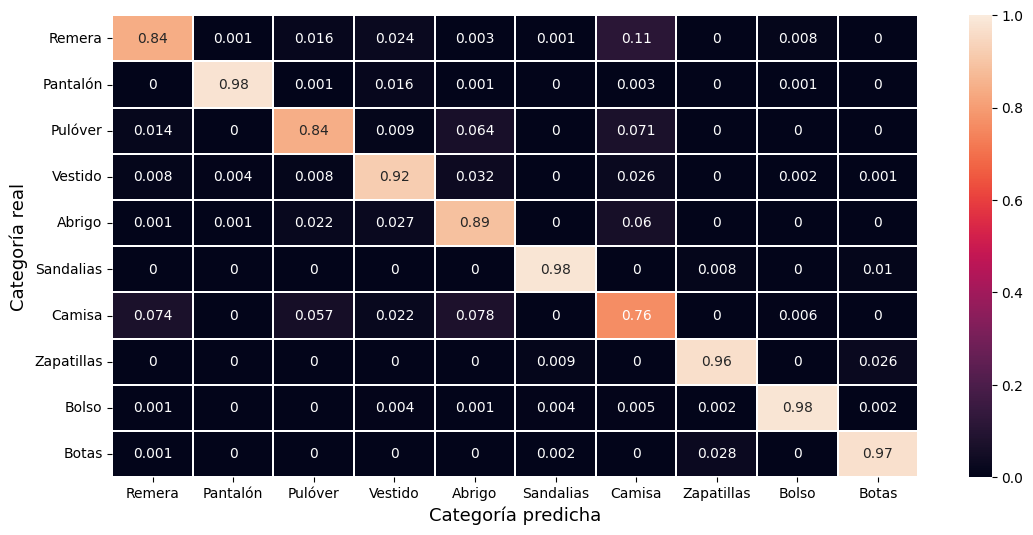

In [ ]:
classes = list(labels_names.values())
clases_esp = ['Remera', 'Pantalón', 'Pulóver', 'Vestido', 'Abrigo', 'Sandalias', 'Camisa', 'Zapatillas', 'Bolso', 'Botas']
df_cm = pd.DataFrame(cm[0], index = clases_esp, columns = clases_esp)
plt.figure(figsize = (13,6))

sn.heatmap(df_cm, annot = True, vmin=0, vmax=1, linecolor = 'white', linewidths = 0.01)
plt.ylabel('Categoría real', fontsize = 13)
plt.xlabel('Categoría predicha', fontsize = 13)

plt.savefig('confusion matrix grande.pdf', bbox_inches='tight')

In [ ]:
cm = confusion_matrix(test_set_orig, model)

Matriz de confusión completada! Precision=90.7%


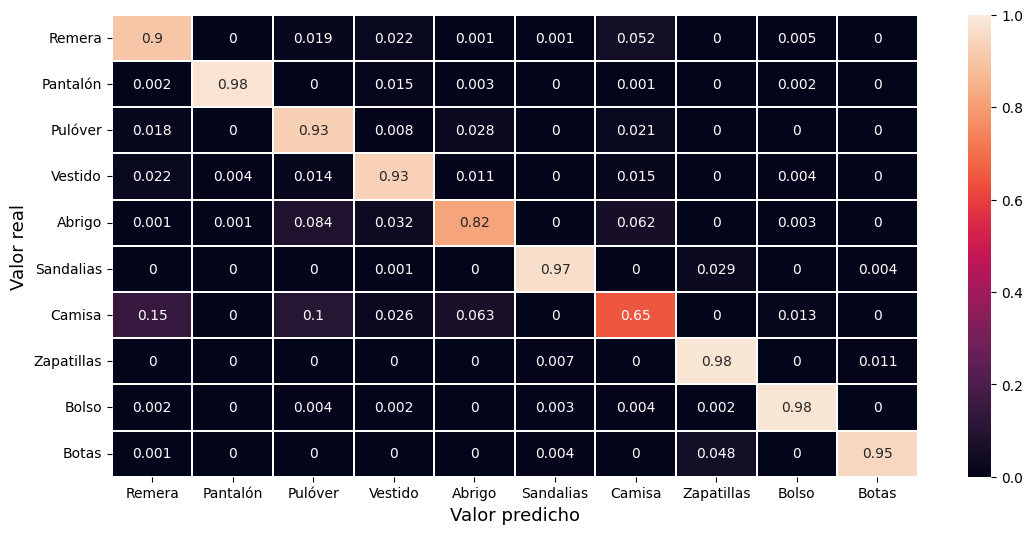

In [ ]:
classes = list(labels_names.values())
clases_esp = ['Remera', 'Pantalón', 'Pulóver', 'Vestido', 'Abrigo', 'Sandalias', 'Camisa', 'Zapatillas', 'Bolso', 'Botas']
df_cm = pd.DataFrame(cm[0], index = clases_esp, columns = clases_esp)
plt.figure(figsize = (13,6))

sn.heatmap(df_cm, annot = True, vmin=0, vmax=1, linecolor = 'white', linewidths = 0.01)
plt.ylabel('Valor real', fontsize = 13)
plt.xlabel('Valor predicho', fontsize = 13)
plt.show()

Está normalizado sobre el numero de veces que aparece cada clase en el test set. Es decir que se lee como "El 98% de las veces que la imagen fue un pantalón, el modelo acertó" y "El 0,1% de las veces que la imagen fue un pantalón el modelo predijo un Pullover"

# Entreno solo clasificador

In [ ]:
model = Clasificador_Conv(n=64, p=0.2, autoencoder = autoencoder)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.clasificador.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.616988  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=1.325518  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=1.115513  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.813579  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.892512  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.805074  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=76.4% avg_loss=0.882321
Validation set:
@valid_loop precision=75.6% avg_loss=0.897901

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.894017  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.851570  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.649207  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.739320  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.675386  muestras-procesadas=[40000/6

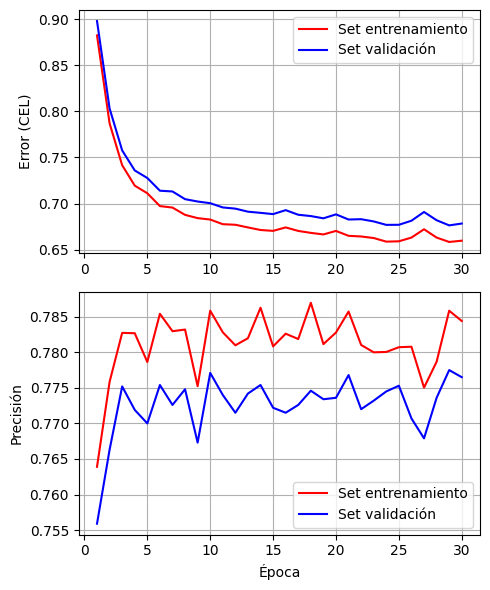

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=64
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_solo_entrenado_E30_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_solo_E30_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

# Sin preentrenamiento

In [ ]:
model = Clasificador_Conv(n=64, p=0.2)

Encoder Creado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.306503  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.841451  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.744402  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.551953  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.489884  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.524685  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=83.2% avg_loss=0.525250
Validation set:
@valid_loop precision=82.2% avg_loss=0.540677

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.558904  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.559851  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.468197  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.561565  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.383627  muestras-procesadas=[40000/6

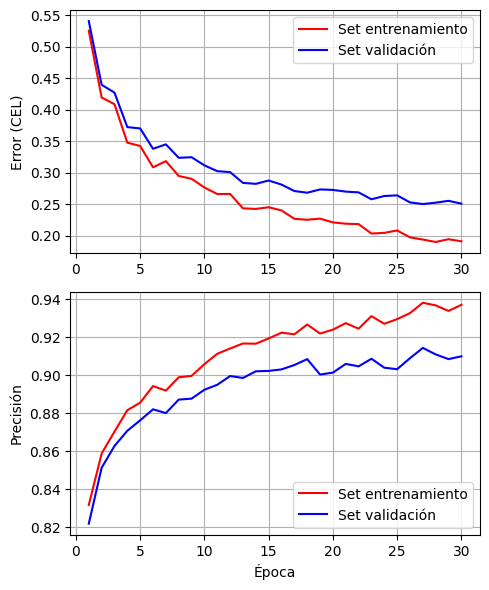

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=64
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_sin_pre2_E30_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_sin_pre2_E30_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

# Otras variantes

### Pruebo con Sigmoid a la salida

In [ ]:
# 4.1)
class Clasificador_Conv(nn.Module):
  def __init__(self, n, p=0.2, autoencoder = None, sigmoid = False):
    super().__init__() # Toma los metodos en init de la clase q estoy heredando, equivalente a hacer "nn.Module.__init__()"
    self.flatten = nn.Flatten()

    self.pretraining = False
    if autoencoder is None:

      self.n = n
      self.p = p
      self.encoder = nn.Sequential(
          # Convolutional
          nn.Conv2d(1, 16, kernel_size = 3), # (1,28,28) -> (16,26,26)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (16,26,26) -> (16,13,13)

          # Convolutional
          nn.Conv2d(16, 32, kernel_size = 3), # (16,13,13) -> (32,11,11)
          nn.ReLU(),
          nn.Dropout(p),
          nn.MaxPool2d(2,2), # (32,11,11) -> (32,5,5)

          # Linear
          nn.Flatten(),  # (32,5,5) -> (32*5*5)
          nn.Linear(32*5*5, n), # (32*5*5) -> n
          nn.ReLU(),
          nn.Dropout(p)
      )
      print('Encoder Creado!')
    else:
      self.n = autoencoder.n
      self.p = autoencoder.p
      self.pretraining = True
      self.encoder = copy.deepcopy(autoencoder.encoder)
      print('Encoder Copiado!')

    if sigmoid:
      self.clasificador = nn.Sequential(
          nn.Linear(self.n, 10),
          nn.Sigmoid()
      )
    else:
      self.clasificador = nn.Sequential(
          nn.Linear(self.n, 10),
          nn.ReLU()
      )

  def forward(self, x):#, Train = False):
    x = self.encoder(x)
    x = self.clasificador(x)
    return x

In [ ]:
model = Clasificador_Conv(n=64, p=0.2, autoencoder = autoencoder, sigmoid=True)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.282785  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=1.705297  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=1.672550  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=1.618894  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=1.662166  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=1.615274  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=75.2% avg_loss=1.607563
Validation set:
@valid_loop precision=74.3% avg_loss=1.614134

Epoch 2
-------------------------------
@train_loop batch=    0 loss=1.561569  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=1.590382  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=1.577681  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=1.614157  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=1.628554  muestras-procesadas=[40000/6

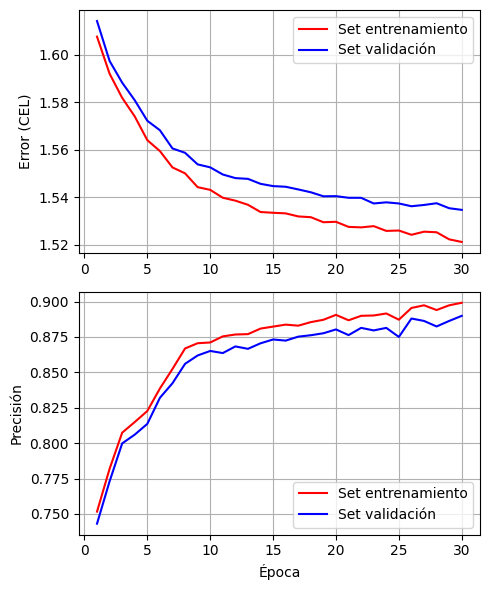

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=64
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_sigm_entrenado_E30_{n}.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_sigm_E30_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

### Estadística con las épocas

Voy a entrenar muchas veces una misma red de n=64 en 50 epocas asi puedo hacer un análisis estadístico del impacto de las épocas.

Voy a guardar todos los arrays de loss y de precisión en un DataFrame estructurado como sigue:

50 filas, 1 por cada época. 2xN columnas 2 por cada modelo entrenado, una para Precisión y otra para Loss.

In [ ]:
df_estadistica = pd.DataFrame()

In [ ]:
cant_entrenamientos = 5 # Voy a entrenar de 5 en 5

batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)


for k in range(cant_entrenamientos):

  num_epochs = 50
  model = Clasificador_Conv(n=64, p=0.2, autoencoder = autoencoder)
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3, eps=1e-08,weight_decay=0,amsgrad=False)
  loss_fn = nn.CrossEntropyLoss()

  # Pasamos el modelo al dispositivo
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  print(f'Device: {device}')

  list_train_avg_loss = []
  list_valid_avg_loss = []
  list_train_precision = []
  list_valid_precision = []
  for epoch in range(num_epochs):
      if epoch != 0: print()
      print(f"Epoch {epoch+1}\n-------------------------------")
      train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True, text = False)
      print('Training set:')
      train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
      print('Validation set:')
      valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

      # Guardo errores
      list_train_avg_loss.append(train_avg_loss)
      list_valid_avg_loss.append(valid_avg_loss)
      list_train_precision.append(train_precision)
      list_valid_precision.append(valid_precision)
  print(f'ENTRENAMIENTO {k+1} LISTO! Precisión = {valid_precision*100}%')

  N = df_estadistica.shape[1]/4
  df_estadistica[f'list_train_precision_{N}'] = list_train_precision
  df_estadistica[f'list_valid_precision_{N}'] = list_valid_precision
  df_estadistica[f'list_train_avg_loss_{N}'] = list_train_avg_loss
  df_estadistica[f'list_valid_avg_loss_{N}'] = list_valid_avg_loss
  print(f'Nro de modelos entrenados: {N+1}')

  df_estadistica.to_csv(f'df_estad_clasif_N{N}.csv', index=False)


Encoder Copiado!
Device: cpu
Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.660751  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.912852  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.799826  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.500848  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.680582  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.478557  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=84.7% avg_loss=0.479057
Validation set:
@valid_loop precision=83.2% avg_loss=0.499582

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.531975  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.604495  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.513426  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.466228  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.484683 

# Análisis nuevo

### Comparo n

In [ ]:
# IMPORTO ADAM
modelos_n = []
list_n = np.array([64, 128, 256, 512])
p = 0.2

for i, n in enumerate(list_n):
  # Crear una instancia del modelo
  model = Autoencoder_Conv(n=n, p=p)

  # Crear una instancia del optimizador
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)

  # Cargar los parámetros del modelo desde el archivo guardado
  checkpoint = torch.load(f'modelo_entrenado_vario_n_{n}.pth')
  model.load_state_dict(checkpoint['modelo_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

  # Colocar el modelo y el optimizador en modo de evaluación
  model.eval()
  modelos_n.append(model)


In [ ]:
list_test_avg_loss_n = np.zeros(4)
batch_size = 100
loss_fn = nn.MSELoss()
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)

for i, l in enumerate(list_test_avg_loss_n):
  model = modelos_n[i]
  test_avg_loss = valid_loop(valid_loader, model,loss_fn)
  list_test_avg_loss_n[i] = test_avg_loss

@valid_loop avg_loss=0.036639
@valid_loop avg_loss=0.030721
@valid_loop avg_loss=0.030641
@valid_loop avg_loss=0.029154


1258


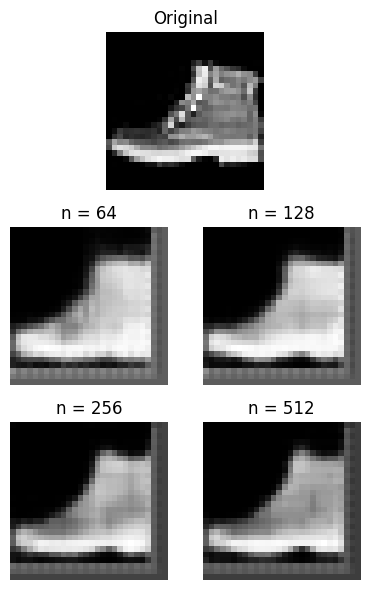

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

modelos = modelos_n

# Crear la grilla con 6 filas y 4 columnas
gs = GridSpec(6, 4)

# Crear una figura
fig = plt.figure(figsize=(4, 6))

# Tomo una imagen del set de testeo
j = torch.randint(len(valid_set),size=(1,)).item()
image, _ = train_set[j]
print(j)

# Definir los límites para la primera imagen
ax1 = plt.subplot(gs[:2, 1:3])
ax1.axis('off')  # Ocultar los ejes para la primera imagen

# Definir los límites para las otras cuatro imágenes
ax2 = plt.subplot(gs[2:4, :2])
ax3 = plt.subplot(gs[2:4, 2:])
ax4 = plt.subplot(gs[4:6, :2])
ax5 = plt.subplot(gs[4:6, 2:])

# Mostrar las imágenes en los ejes correspondientes
ax1.imshow(image.squeeze(), cmap = 'Greys_r')
ax1.set_title('Original')

for i, ax in enumerate([ax2, ax3, ax4, ax5]):
  image_gpu = image.to(device)
  pred_gpu = modelos[i](batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
  pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
  ax.imshow(pred_cpu, cmap = 'Greys_r')
  ax.set_title(f'n = {list_n[i]}')
  ax.axis('off')


# Ajustar el espaciado entre las subfiguras
plt.tight_layout()

# Mostrar la figura
plt.show()

### Entreno con n=128

Entreno el autoencoder

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 128, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# Entrenamiento iterando en epocas
num_epochs = 20

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.043032
Validation set:
@valid_loop avg_loss=0.043104

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.037720
Validation set:
@valid_loop avg_loss=0.037832

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.033195
Validation set:
@valid_loop avg_loss=0.033317

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.031641
Validation set:
@valid_loop avg_loss=0.031779

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.030330
Validation set:
@valid_loop avg_loss=0.030477

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.028380
Validation set:
@valid_loop avg_loss=0.028540

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.028807
Validation set:
@valid_loop avg_loss=0.028958

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.028592

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'autoencoder_entrenado_128.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_avg_loss_inc': list_train_avg_loss_inc,  # Convertir el array a una dimensión
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_autoenc_128.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

In [ ]:
# Crear una instancia del modelo
model = Autoencoder_Conv(n=512, p=0.2)
# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)
# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'autoencoder_entrenado_128.pth')
model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

autoencoder = model

In [ ]:
model = Clasificador_Conv(n=512, p=0.2, autoencoder = autoencoder)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.351089  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.558565  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.456103  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.357538  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.456904  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.447808  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=87.3% avg_loss=0.393033
Validation set:
@valid_loop precision=86.2% avg_loss=0.416147

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.411258  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.324253  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.334102  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.373353  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.315879  muestras-procesadas=[40000/6

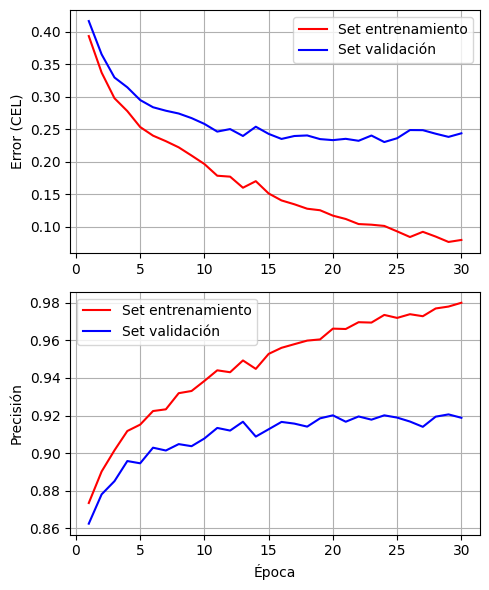

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=512
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_E30_512.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_E30_512.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

### Entreno con n=512

Entreno el autoencoder

In [ ]:
# Defino las variables con las que alimento el loop

# Creamos los DataLoaders
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.MSELoss()

# Definimos el modelo
n, p = 512, 0.2
model = Autoencoder_Conv(n, p)

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# Entrenamiento iterando en epocas
num_epochs = 20

list_train_avg_loss_inc = []
list_train_avg_loss = []
list_valid_avg_loss = []

# lr_lambda = lambda epoch: 3/(epoch+1)
# scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

for epoch in range(num_epochs):
  if epoch != 0: print()
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_avg_loss_inc = train_loop(train_loader, model,loss_fn, optimizer, text = False)
  print('Training set:')
  train_avg_loss = valid_loop(train_loader, model,loss_fn)
  print('Validation set:')
  valid_avg_loss = valid_loop(valid_loader, model,loss_fn)
  # scheduler.step()

  list_train_avg_loss_inc.append(train_avg_loss_inc)
  list_train_avg_loss.append(train_avg_loss)
  list_valid_avg_loss.append(valid_avg_loss)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
Training set:
@valid_loop avg_loss=0.043032
Validation set:
@valid_loop avg_loss=0.043104

Epoch 2
-------------------------------
Training set:
@valid_loop avg_loss=0.037720
Validation set:
@valid_loop avg_loss=0.037832

Epoch 3
-------------------------------
Training set:
@valid_loop avg_loss=0.033195
Validation set:
@valid_loop avg_loss=0.033317

Epoch 4
-------------------------------
Training set:
@valid_loop avg_loss=0.031641
Validation set:
@valid_loop avg_loss=0.031779

Epoch 5
-------------------------------
Training set:
@valid_loop avg_loss=0.030330
Validation set:
@valid_loop avg_loss=0.030477

Epoch 6
-------------------------------
Training set:
@valid_loop avg_loss=0.028380
Validation set:
@valid_loop avg_loss=0.028540

Epoch 7
-------------------------------
Training set:
@valid_loop avg_loss=0.028807
Validation set:
@valid_loop avg_loss=0.028958

Epoch 8
-------------------------------
Training set:
@valid_loop avg_loss=0.028592

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'autoencoder_entrenado_512.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_avg_loss_inc': list_train_avg_loss_inc,  # Convertir el array a una dimensión
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_autoenc_512.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

In [ ]:
# Crear una instancia del modelo
model = Autoencoder_Conv(n=512, p=0.2)
# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)
# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'autoencoder_entrenado_512.pth')
model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

autoencoder = model

In [ ]:
model = Clasificador_Conv(n=512, p=0.2, autoencoder = autoencoder)

Encoder Copiado!


In [ ]:
# Creamos los DataLoaders con los datasets originales
batch_size = 100
train_loader = DataLoader(train_set_orig, batch_size=batch_size,shuffle=True)
valid_loader = DataLoader(test_set_orig, batch_size=batch_size,shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size,shuffle=True)

# Creamos una instancia de una función de pérdida, una entropy loss en este caso
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.MSELoss()

# Creamos un optimizador, un Stochastic Gradient Descent, en este caso.
learning_rate = 1e-3 # necesario para definir
# optimizer = torch.optim.SGD(model.parameters(),lr=1, momentum = 0.9 , dampening = 0.3)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, eps=1e-08,weight_decay=0,amsgrad=False)

# Determinamos en que dispositivo vamos a trabajar, una CPU o una GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Pasamos el modelo al dispositivo
model = model.to(device)
print(f'Device: {device}')

Device: cpu


In [ ]:
# 5.8) y 5.9)
# Finalmente, entrenamos iterando sobre épocas.
# Además, testeamos el modelo en cada una de ellas.
num_epochs = 30
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    if epoch != 0: print()
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_avg_loss_incorrecta,train_precision_incorrecta = train_loop(train_loader,model,loss_fn,optimizer, clasificador = True)
    print('Training set:')
    train_avg_loss,train_precision = valid_loop(train_loader,model,loss_fn, clasificador = True)
    print('Validation set:')
    valid_avg_loss,valid_precision = valid_loop(valid_loader,model,loss_fn, clasificador = True)

    # Guardo errores
    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)
    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)
print('ENTRENAMIENTO LISTO!')

Epoch 1
-------------------------------
@train_loop batch=    0 loss=2.351089  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.558565  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.456103  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.357538  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.456904  muestras-procesadas=[40000/60000]
@train_loop batch=  500 loss=0.447808  muestras-procesadas=[50000/60000]
Training set:
@valid_loop precision=87.3% avg_loss=0.393033
Validation set:
@valid_loop precision=86.2% avg_loss=0.416147

Epoch 2
-------------------------------
@train_loop batch=    0 loss=0.411258  muestras-procesadas=[    0/60000]
@train_loop batch=  100 loss=0.324253  muestras-procesadas=[10000/60000]
@train_loop batch=  200 loss=0.334102  muestras-procesadas=[20000/60000]
@train_loop batch=  300 loss=0.373353  muestras-procesadas=[30000/60000]
@train_loop batch=  400 loss=0.315879  muestras-procesadas=[40000/6

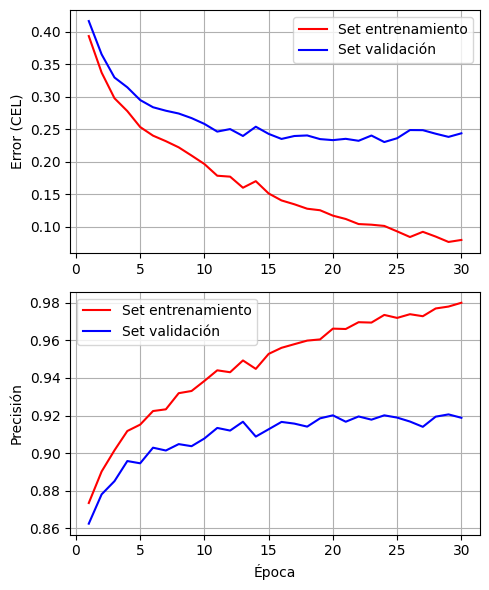

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_avg_loss,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_avg_loss,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend()
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,len(list_train_avg_loss)+1),list_train_precision,label="Set entrenamiento",linestyle='-',c='red')
ax.plot(range(1,len(list_train_avg_loss)+1),list_valid_precision,label="Set validación",linestyle='-',c='blue')

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()
ax.legend()
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

In [ ]:
# Guardo el modelo entrenado como archivo de PyTorch
n=512
torch.save({
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
}, f'clasif_E30_512.pth')

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_precision': list_train_precision,
    'list_valid_precision': list_valid_precision,
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_clasif_E30_512.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

### Comparacion autoencoders


64: @valid_loop avg_loss=0.036639 o 0.037261 (REFERENCIA)

128: @valid_loop avg_loss=0.030721

256: @valid_loop avg_loss=0.030641

512: @valid_loop avg_loss=0.029154

----------------------------------

batch 1000: 0.0436

batch 10: 0.037016

-------------------------------
p = 0.2: 0.037261

p = 0.05: 0.025174

p = 0.01: 0.022691

p=0.001: 0.022952

p=0.005: 0.023021

----------------------------

lr= 0.0001 -- loss: 0.042028 (suaviza la curva pero porque no logra bajar de 0.042 que es donde se hace lio para el de lr=0.001)

lr= 0.01 -- loss: 0.037016 (se hace todavia mas rugosa)


In [ ]:
p_list = [0.2,0.05,0.01,0.0001, 0.01]
p_error = [0.03726,0.02517,0.02291,0.02295, 0.020703]

n_list = [64,128,256,512,128]
n_error = [0.03726,0.030721,0.03064,0.02915]



plt.figure(figsize = (5,3))
plt.plot(list_n, list_test_avg_loss, "o", label = 'SGD')

# plt.plot(list_n, list_test_avg_loss_adam, "o", label = 'Adam')
plt.xticks(list_n)
# plt.yticks(list_test_avg_loss)
plt.xlabel('Nro de neuronas (n)')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend()
# plt.minorticks('on')


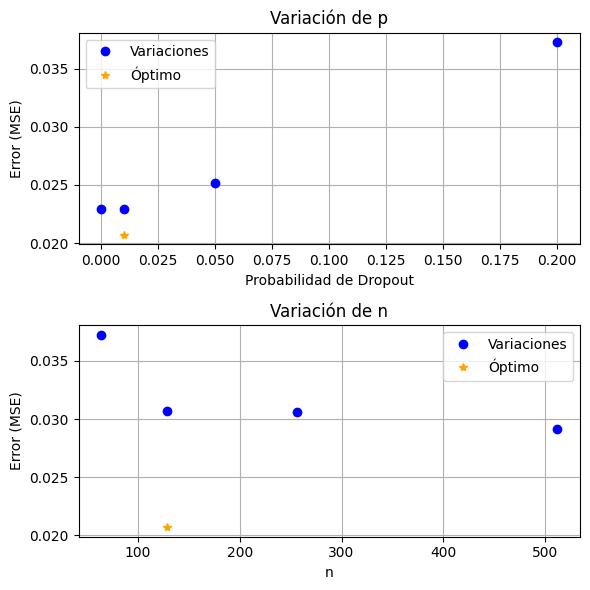

In [ ]:
p_list = [0.2,0.05,0.01,0.0001, 0.01]
p_error = [0.03726,0.02517,0.02291,0.02295, 0.020703]

n_list = [64,128,256,512,128]
n_error = [0.03726,0.030721,0.03064,0.02915,  0.020703]

fig, axs = plt.subplots(2,1, figsize=(6,6))

# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(p_list[:-1], p_error[:-1],'o', label="Variaciones", c='blue')
ax.plot(p_list[-1], p_error[-1],'*', label="Óptimo", c='orange')

# ax.plot(range(1,num_epochs+1),list_valid_avg_loss[i],label="Set validación",linestyle='-',c='blue')
ax.set_xlabel('Probabilidad de Dropout')
ax.set_ylabel('Error (MSE)')
ax.title.set_text(f'Variación de p')
ax.grid()
ax.legend()
# ax.set_ylim((0.024, 0.03))
# ax.set_xlim((5, 32))

k = 1
i=3
ax = axs.ravel()[k]
ax.plot(n_list[:-1], n_error[:-1],'o', label="Variaciones", c='blue')
ax.plot(n_list[-1], n_error[-1],'*', label="Óptimo", c='orange')

# ax.plot(range(1,num_epochs+1),list_valid_avg_loss[i],label="Set validación",linestyle='-',c='blue')
ax.set_xlabel('n')
ax.set_ylabel('Error (MSE)')
ax.title.set_text(f'Variación de n')
ax.grid()
ax.legend()
# ax.set_ylim((0.01, 0.015))
# ax.set_xlim((5, 32))

fig.tight_layout()

In [ ]:
base_df = pd.read_csv('losses_df_P2_64.csv')
base_df

,list_train_avg_loss_inc,list_train_avg_loss,list_valid_avg_loss
0,0.066858,0.047033,0.047070
1,0.045920,0.042638,0.042710
2,0.041514,0.041210,0.041311
3,0.038954,0.041417,0.041507
4,0.037421,0.040402,0.040512
5,0.036523,0.038034,0.038136
6,0.035959,0.038486,0.038597
7,0.035569,0.036964,0.037068
8,0.035267,0.037009,0.037120
9,0.035050,0.037786,0.037896


# Gráficos

In [ ]:
# Crear una instancia del modelo
model128 = Autoencoder_Conv(n=128, p=0.01)

# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model128.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)

# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'/content/autoencoder_entrenado_128.pth')
model128.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

In [ ]:
# Crear una instancia del modelo
model64 = Autoencoder_Conv(n=64, p=0.2)

# Crear una instancia del optimizador
optimizer = torch.optim.Adam(model64.parameters(),lr=1e-3,eps=1e-08,weight_decay=0,amsgrad=False)

# Cargar los parámetros del modelo desde el archivo guardado
checkpoint = torch.load(f'modelo_entrenado_P2_64.pth')
model64.load_state_dict(checkpoint['modelo_state_dict'])
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])

In [ ]:
# Crear un DataFrame de pandas
losses_df = pd.DataFrame({
    'list_train_avg_loss_inc': list_train_avg_loss_inc,  # Convertir el array a una dimensión
    'list_train_avg_loss': list_train_avg_loss,
    'list_valid_avg_loss': list_valid_avg_loss
})

# Exportar el DataFrame a un archivo CSV
losses_df.to_csv(f'losses_df_P2_{n}.csv', index=False)  # El argumento index=False evita que se añada una columna de índices al CSV

In [ ]:
losses_df64 = pd.read_csv('/content/losses_df_P2_64.csv')
list_train_avg_loss64 =    losses_df64['list_train_avg_loss']
list_valid_avg_loss64  =  losses_df64['list_valid_avg_loss']

losses_df128 = pd.read_csv('/content/losses_df_autoencoder_entrenado_128.csv')
list_train_avg_loss128 =    losses_df128['list_train_avg_loss']
list_valid_avg_loss128  =  losses_df128['list_valid_avg_loss']


In [ ]:
len(list_train_avg_loss64)

20

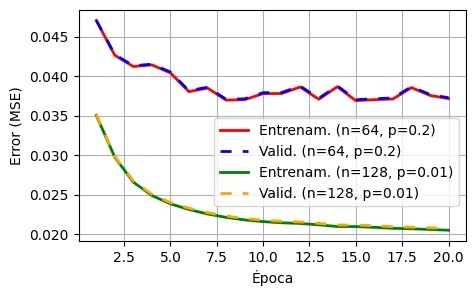

In [ ]:
plt.figure(figsize = (5,3))
num_epochs = len(list_train_avg_loss64)
# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss64,label="Entrenam. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss64,label="Valid. (n=64, p=0.2)",linestyle=(0,(4,4)),c='blue', lw = 2)

plt.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.01)",linestyle='-',c='green', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.01)",linestyle=(0,(4,4)),c='orange', lw = 2)

plt.xlabel('Época')
plt.ylabel('Error (MSE)')
plt.grid()
plt.legend(loc = (0.35,0.15))
plt.savefig('autoencoder 64 vs 128.pdf',   bbox_inches='tight')

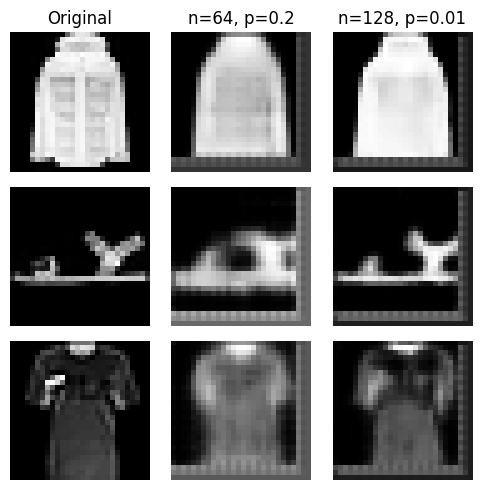

In [ ]:
from matplotlib.gridspec import GridSpec
# CON ADAM:
# Hago la figura de 3x3
fig, axs = plt.subplots(3,3, figsize=(5, 5))
label = {0: 'Original', 1: 'n=64, p=0.2', 2: 'n=128, p=0.01'}
model.eval()
for i, ax_ in enumerate(axs):
  j = torch.randint(len(train_set),size=(1,)).item()
  image, _ = train_set[j]
  for k, ax in enumerate(ax_):
    ax.axis('off')
    if i==0:
      ax.title.set_text(label[k])
    if k==0:
      ax.imshow(image.squeeze(), cmap = 'Greys_r')
    else:
      if k==1:
        model = model64
        model.eval()
      elif k==2:
        model = model128
        model.eval()
      image_gpu = image.to(device)
      pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
      pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
      ax.imshow(pred_cpu, cmap = 'Greys_r')

# fig.suptitle('ADAM n=64', fontsize=14)
fig.tight_layout()
plt.show( )

In [ ]:
# Lo pongo a prueba...
# Hago la figura de 3x3
fig, axs = plt.subplots(3,2,figsize = (4,5))
label = {0: 'Original', 1: 'Filtrado'}
model.eval()
for i, ax_ in enumerate(axs):
  j = torch.randint(len(train_set),size=(1,)).item()
  image, _ = train_set[j]
  for k, ax in enumerate(ax_):
    ax.axis('off')
    if i==0:
      ax.title.set_text(label[k])
    if k==0:
      ax.imshow(image.squeeze(), cmap = 'Greys_r')
    else:
      image_gpu = image.to(device)
      pred_gpu = model(batch(image_gpu)) # Primero la hago tensor de 3 dim con batch, despues la paso por el modelo
      pred_cpu = unbatch(pred_gpu) # La paso a la CPU y la hago tensor de 2 dim para matplotlib
      ax.imshow(pred_cpu, cmap = 'Greys_r')
fig.suptitle(f'MSE = {list_valid_avg_loss[-1]:.4f}', fontsize=14)
plt.show( )

## Comparación clasificadores


In [ ]:
losses_df64 = pd.read_csv('/content/losses_df_clasif_E50_64.csv')
list_train_avg_loss64 =    losses_df64['list_train_avg_loss']
list_valid_avg_loss64  =  losses_df64['list_valid_avg_loss']
list_train_precision64 =    losses_df64['list_train_precision']
list_valid_precision64=  losses_df64['list_valid_precision']

losses_df128 = pd.read_csv('/content/df_estad_clasif_128_02_MalaCI.csv')
list_train_avg_loss128 =    losses_df128['list_train_avg_loss']
list_valid_avg_loss128  =  losses_df128['list_valid_avg_loss']
list_train_precision128 =    losses_df128['list_train_precision']
list_valid_precision128  =  losses_df128['list_valid_precision']

losses_df128 = pd.read_csv('/content/df_clasif_128_001.csv')
list_train_avg_loss128_001 =    losses_df128['list_train_avg_loss']
list_valid_avg_loss128_001  =  losses_df128['list_valid_avg_loss']
list_train_precision128_001 =    losses_df128['list_train_precision']
list_valid_precision128_001  =  losses_df128['list_valid_precision']


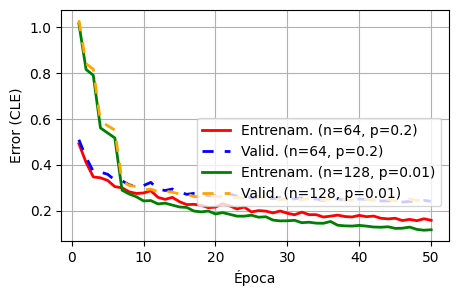

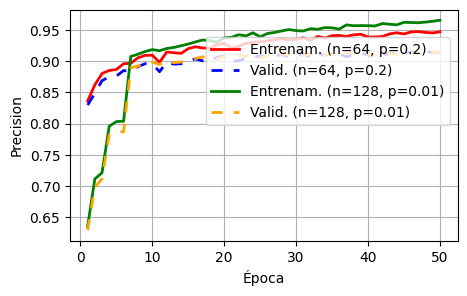

In [ ]:
plt.figure(figsize = (5,3))
num_epochs = len(list_train_avg_loss64)
# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_avg_loss64,label="Entrenam. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss64,label="Valid. (n=64, p=0.2)",linestyle=(0,(4,4)),c='blue', lw = 2)

plt.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.01)",linestyle='-',c='green', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.01)",linestyle=(0,(4,4)),c='orange', lw = 2)

plt.xlabel('Época')
plt.ylabel('Error (CLE)')
plt.grid()
plt.legend(loc = (0.35,0.15))


plt.figure(figsize = (5,3))
num_epochs = len(list_train_avg_loss64)
# plt.plot(range(1,num_epochs+1), list_train_avg_loss_inc[0],label="Durante Entrenamiento",linestyle='-',c='red')
plt.plot(range(1,num_epochs+1), list_train_precision64,label="Entrenam. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_precision64,label="Valid. (n=64, p=0.2)",linestyle=(0,(4,4)),c='blue', lw = 2)

plt.plot(range(1,num_epochs+1), list_train_precision128,label="Entrenam. (n=128, p=0.01)",linestyle='-',c='green', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_precision128,label="Valid. (n=128, p=0.01)",linestyle=(0,(4,4)),c='orange', lw = 2)

plt.xlabel('Época')
plt.ylabel('Precision')
plt.grid()
plt.legend(loc = (0.35,0.5))

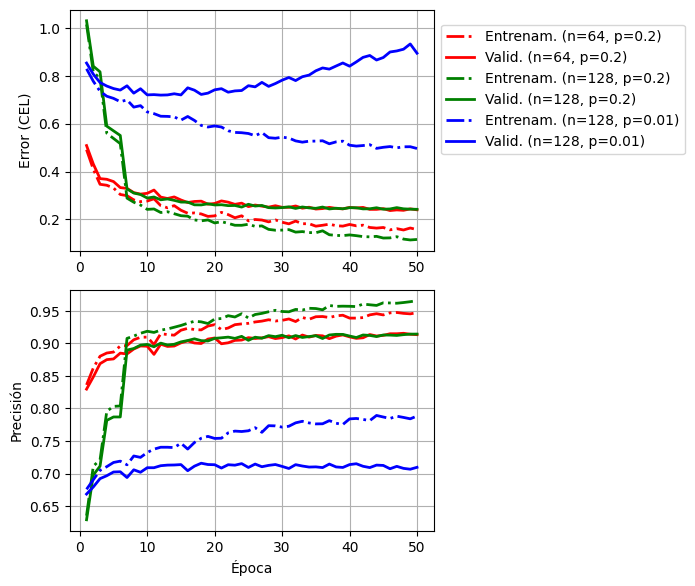

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(7,6))
# linestyle=(0,(4,4))
# for i, n in enumerate(list_n):
num_epochs = len(list_train_avg_loss64)
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_avg_loss64,label="Entrenam. (n=64, p=0.2)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss64,label="Valid. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)


ax.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.2)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.2)",linestyle='-',c='green', lw = 2)


ax.plot(range(1,num_epochs+1), list_train_avg_loss128_001,label="Entrenam. (n=128, p=0.01)",linestyle='-.',c='blue', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss128_001,label="Valid. (n=128, p=0.01)",linestyle='-',c='blue', lw = 2)

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend(loc = (1.02,0.4))
# ax.legend(loc = (0.1,0.60))

# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_precision64,label="Entrenam. (n=64, p=0.2)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision64,label="Valid. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_train_precision128,label="Entrenam. (n=128, p=0.2)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision128,label="Valid. (n=128, p=0.2)",linestyle='-',c='green', lw = 2)

ax.plot(range(1,num_epochs+1), list_train_precision128_001,label="Entrenam. (n=128, p=0.01)",linestyle='-.',c='blue', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision128_001,label="Valid. (n=128, p=0.01)",linestyle='-',c='blue', lw = 2)

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()

# ax.legend(loc = (0.35,0.05))
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

plt.savefig('comparacion clasif.pdf')

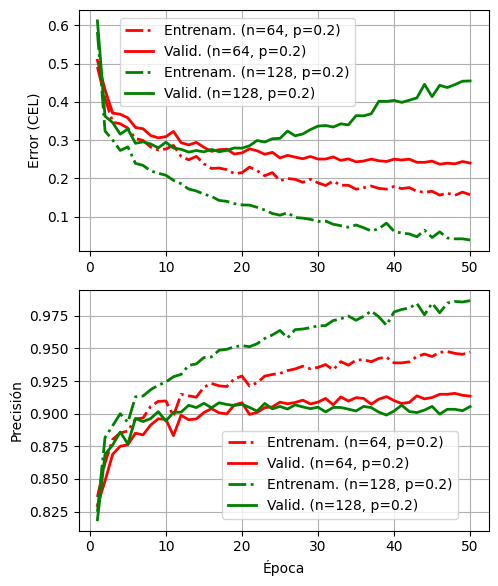

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))
# linestyle=(0,(4,4))
# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_avg_loss64,label="Entrenam. (n=64, p=0.2)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss64,label="Valid. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)


ax.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.2)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.2)",linestyle='-',c='green', lw = 2)


# ax.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.01)",linestyle='-.',c='green', lw = 2)
# ax.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.01)",linestyle='-',c='green', lw = 2)

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend(loc = (0.1,0.60))
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_precision64,label="Entrenam. (n=64, p=0.2)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision64,label="Valid. (n=64, p=0.2)",linestyle='-',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_train_precision128,label="Entrenam. (n=128, p=0.2)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision128,label="Valid. (n=128, p=0.2)",linestyle='-',c='green', lw = 2)

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()

ax.legend(loc = (0.35,0.05))
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

# Comparo preentrenamiento

In [ ]:
losses_df64 = pd.read_csv('/content/losses_df_clasif_E50_64.csv')[:30]
list_train_avg_loss64 =    losses_df64['list_train_avg_loss']
list_valid_avg_loss64  =  losses_df64['list_valid_avg_loss']
list_train_precision64 =    losses_df64['list_train_precision']
list_valid_precision64=  losses_df64['list_valid_precision']

losses_df128 = pd.read_csv('/content/losses_df_clasif_sin_pre_E30_64.csv')
list_train_avg_loss128 =    losses_df128['list_train_avg_loss']
list_valid_avg_loss128  =  losses_df128['list_valid_avg_loss']
list_train_precision128 =    losses_df128['list_train_precision']
list_valid_precision128  =  losses_df128['list_valid_precision']

# losses_df128 = pd.read_csv('/content/df_clasif_128_001.csv')
# list_train_avg_loss128_001 =    losses_df128['list_train_avg_loss']
# list_valid_avg_loss128_001  =  losses_df128['list_valid_avg_loss']
# list_train_precision128_001 =    losses_df128['list_train_precision']
# list_valid_precision128_001  =  losses_df128['list_valid_precision']


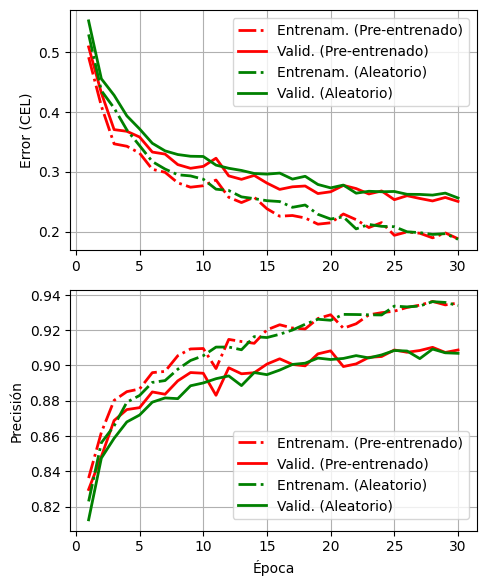

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(5,6))
num_epochs = len(list_train_avg_loss64)
# linestyle=(0,(4,4))
# for i, n in enumerate(list_n):
k = 0
i= 0
ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_avg_loss64,label="Entrenam. (Pre-entrenado)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss64,label="Valid. (Pre-entrenado)",linestyle='-',c='red', lw = 2)


ax.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (Aleatorio)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (Aleatorio)",linestyle='-',c='green', lw = 2)


# ax.plot(range(1,num_epochs+1), list_train_avg_loss128,label="Entrenam. (n=128, p=0.01)",linestyle='-.',c='green', lw = 2)
# ax.plot(range(1,num_epochs+1), list_valid_avg_loss128,label="Valid. (n=128, p=0.01)",linestyle='-',c='green', lw = 2)

ax.set_ylabel('Error (CEL)')
# ax.title.set_text(f'n = {512}')
ax.grid()
ax.legend(loc = (0.40,0.6))
# ax.set_ylim((0.006, 0.01))
# ax.set_xlim((5, 32))


k = 1

ax = axs.ravel()[k]
ax.plot(range(1,num_epochs+1), list_train_precision64,label="Entrenam. (Pre-entrenado)",linestyle='-.',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision64,label="Valid. (Pre-entrenado)",linestyle='-',c='red', lw = 2)
ax.plot(range(1,num_epochs+1), list_train_precision128,label="Entrenam. (Aleatorio)",linestyle='-.',c='green', lw = 2)
ax.plot(range(1,num_epochs+1), list_valid_precision128,label="Valid. (Aleatorio)",linestyle='-',c='green', lw = 2)

ax.set_ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
ax.grid()

ax.legend(loc = (0.40,0.05))
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
ax.set_xlabel('Época')
fig.tight_layout()

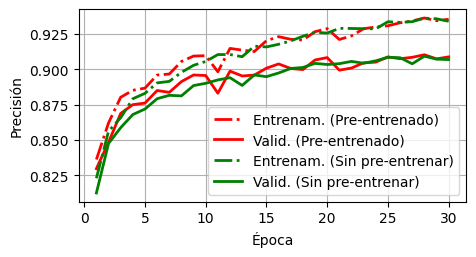

In [ ]:
plt.figure(figsize=(5,2.5))
plt.plot(range(1,num_epochs+1), list_train_precision64,label="Entrenam. (Pre-entrenado)",linestyle='-.',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_precision64,label="Valid. (Pre-entrenado)",linestyle='-',c='red', lw = 2)
plt.plot(range(1,num_epochs+1), list_train_precision128,label="Entrenam. (Sin pre-entrenar)",linestyle='-.',c='green', lw = 2)
plt.plot(range(1,num_epochs+1), list_valid_precision128,label="Valid. (Sin pre-entrenar)",linestyle='-',c='green', lw = 2)

plt.ylabel('Precisión')
# ax.title.set_text(f'n = {64}')
plt.grid()

# plt.legend(loc = (0.40,0.05))
# ax.set_ylim((0.017, 0.021))
# ax.set_xlim((5, 32))
plt.xlabel('Época')
# plt.tight_layout()

plt.legend(loc = 'lower right')
fig.tight_layout()
plt.savefig('comparacion preentrenado chico.pdf',   bbox_inches='tight')